IMPORTING THE DATA



In [1]:
import pandas as pd
import nbformat as nbf
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Charger directement le fichier produit (Excel ou CSV)

df_prod = pd.read_csv(r"C:/Users/admin/Documents/stage mexico/VIDEO/1338834.csv")

# Vérifier les premières lignes
print(df_prod.head())


   Year  Week    Department  Product_ID Product_Description Brand  \
0  2023     1  LINEA BLANCA     1338834  30KCILINDROGASDISA  DISA   
1  2023     2  LINEA BLANCA     1338834  30KCILINDROGASDISA  DISA   
2  2023     2  LINEA BLANCA     1338834  30KCILINDROGASDISA  DISA   
3  2023     3  LINEA BLANCA     1338834  30KCILINDROGASDISA  DISA   
4  2023     3  LINEA BLANCA     1338834  30KCILINDROGASDISA  DISA   

     Product_Group    Sales_Cost  Units_Sold  Total_Sales  
0  CILINDRO DE GAS  10552.443158           6     15253.51  
1  CILINDRO DE GAS   1758.740526           1      2559.57  
2  CILINDRO DE GAS  22863.626842          13     33079.67  
3  CILINDRO DE GAS   1758.740526           1      2843.97  
4  CILINDRO DE GAS  12311.183684           7     18502.66  


ADDING FEATURES


In [2]:

# Agréger pour rendre Year + Week unique
df_prod = (
    df_prod.groupby(["Year", "Week"], as_index=False)
    .agg({
        "Total_Sales": "sum",
        "Units_Sold": "sum",
        "Department": "first",
        "Product_ID": "first",
        "Product_Description": "first",
        "Brand": "first",
        "Product_Group": "first"
    })
)

# Créer une date fictive à partir de année + semaine
df_prod["date"] = pd.to_datetime(
    df_prod["Year"].astype(str) + df_prod["Week"].astype(str) + '1',
    format='%Y%W%w'
)

# Tendance (index ordonné)
df_prod = df_prod.sort_values(["Year", "Week"]).reset_index(drop=True)
df_prod["tendance"] = np.arange(len(df_prod))

# Saisonnalité : encodage sin/cos
df_prod["week_sin"] = np.sin(2 * np.pi * df_prod["Week"] / 52)
df_prod["week_cos"] = np.cos(2 * np.pi * df_prod["Week"] / 52)

df_prod["week_angle"] = np.arctan2(df_prod["week_sin"], df_prod["week_cos"])


# Prix
df_prod["price"] = df_prod["Total_Sales"] / df_prod["Units_Sold"]




In [3]:
df_prod.head(20)

,Year,Week,Total_Sales,Units_Sold,Department,Product_ID,Product_Description,Brand,Product_Group,date,tendance,week_sin,week_cos,week_angle,price
0,2023,1,15253.51,6,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-01-02,0,0.120537,9.927089e-01,0.120830,2542.251667
1,2023,2,35639.24,14,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-01-09,1,0.239316,9.709418e-01,0.241661,2545.660000
2,2023,3,21346.63,8,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-01-16,2,0.354605,9.350162e-01,0.362491,2668.328750
3,2023,4,10686.20,4,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-01-23,3,0.464723,8.854560e-01,0.483322,2671.550000
4,2023,5,8014.65,3,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-01-30,4,0.568065,8.229839e-01,0.604152,2671.550000
5,2023,6,23776.80,9,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-02-06,5,0.663123,7.485107e-01,0.724983,2641.866667
6,2023,7,5343.10,2,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-02-13,6,0.748511,6.631227e-01,0.845813,2671.550000
7,2023,8,5343.10,2,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-02-20,7,0.822984,5.680647e-01,0.966644,2671.550000
8,2023,9,15494.99,6,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-02-27,8,0.885456,4.647232e-01,1.087474,2582.498333
9,2023,10,28852.75,11,LINEA BLANCA,1338834,30KCILINDROGASDISA,DISA,CILINDRO DE GAS,2023-03-06,9,0.935016,3.546049e-01,1.208305,2622.977273


MODELE:RANDOM FOREST

In [4]:
# Variables explicatives
X= df_prod[["price", "week_sin", "week_cos"]]
y = df_prod["Units_Sold"]

# Normalisation entre 0 et 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Modèle
model = RandomForestRegressor(random_state=42)
model.fit(X_scaled, y)

# Prédictions
y_pred_rf = model.predict(X_scaled)

# Évaluation
mse_rf = mean_squared_error(y, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y, y_pred_rf)
r2_rf = r2_score(y, y_pred_rf)

print(f"RandomForest -> RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.3f}")


RandomForest -> RMSE: 1.17, MAE: 0.93, R²: 0.864


In [5]:
# Plage de prix à tester
prix_range = np.linspace(df_prod["price"].min(), df_prod["price"].max(), 50)

revenus = []
for p in prix_range:
    X_opt = pd.DataFrame({
        "price": [p],
        "week_sin": [np.sin(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)],
        "week_cos": [np.cos(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)]
    })
    X_opt_scaled = scaler.transform(X_opt)  # Adapter l'échelle
    units_pred = model.predict(X_opt_scaled)[0]
    revenus.append(p * units_pred)

optimal_price = prix_range[np.argmax(revenus)]
print("Prix optimal :", optimal_price)


Prix optimal : 2545.885523809524


In [6]:
print(df_prod["price"])
print(df_prod["price"].min())
print(df_prod["price"].max())

0      2542.251667
1      2545.660000
2      2668.328750
3      2671.550000
4      2671.550000
          ...     
124    2540.116667
125    2653.510000
126    2615.712222
127    2562.795000
128    2639.904000
Name: price, Length: 129, dtype: float64
2211.8533333333335
3174.652


XG Boost


In [7]:
import xgboost as xgb
X = df_prod[["price", "week_sin", "week_cos"]]
y = df_prod["Units_Sold"]

# Normalisation X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Définir le modèle
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Entraîner
xgb_model.fit(X_scaled, y)

# Prédictions
y_pred_xgb = xgb_model.predict(X_scaled)

# Évaluation
mse_xgb = mean_squared_error(y, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y, y_pred_xgb)
r2_xgb = r2_score(y, y_pred_xgb)

print(f"XGBoost -> RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.3f}")

XGBoost -> RMSE: 0.81, MAE: 0.59, R²: 0.935


In [8]:
revenus_xgb = []
for p in prix_range:
    X_opt = pd.DataFrame({
        "price": [p],
        "week_sin": [np.sin(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)],
        "week_cos": [np.cos(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)]
    })

    # Adapter à la même échelle que l'entraînement
    X_opt_scaled = scaler_X.transform(X_opt)

    units_pred = xgb_model.predict(X_opt_scaled)[0]
    revenus_xgb.append(p * units_pred)

optimal_price_xgb = prix_range[np.argmax(revenus_xgb)]
print("Prix optimal XGBoost :", optimal_price_xgb)



Prix optimal XGBoost : 2388.693904761905


LINEAR REGRESSION

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Features et cible (tout le dataset)
X_lin = df_prod[["price", "week_sin", "week_cos"]]
y_lin = df_prod["Units_Sold"]

# Normalisation
scaler_X_lin = MinMaxScaler()
X_lin_scaled = scaler_X_lin.fit_transform(X_lin)

# Modèle
lin_model = LinearRegression()
lin_model.fit(X_lin_scaled, y_lin)

# Prédictions
y_pred_lin = lin_model.predict(X_lin_scaled)

# Évaluation
mse_lin = mean_squared_error(y_lin, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin = mean_absolute_error(y_lin, y_pred_lin)
r2_lin = r2_score(y_lin, y_pred_lin)

print(f"Linéaire -> RMSE: {rmse_lin:.2f}, MAE: {mae_lin:.2f}, R²: {r2_lin:.3f}")


Linéaire -> RMSE: 3.06, MAE: 2.41, R²: 0.066


In [10]:
revenus_lin = []
for p in prix_range:
    X_opt = pd.DataFrame({
        "price": [p],
        "week_sin": [np.sin(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)],
        "week_cos": [np.cos(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)]
    })

    # Normaliser comme pour l'entraînement
    X_opt_scaled = scaler_X_lin.transform(X_opt)

    units_pred = lin_model.predict(X_opt_scaled)[0]
    revenus_lin.append(p * units_pred)

# Trouver le prix optimal
optimal_lin = prix_range[np.argmax(revenus_lin)]
print("Prix optimal (Régression Linéaire) :", optimal_lin)


Prix optimal (Régression Linéaire) : 2211.8533333333335


VISUALISATION

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\util

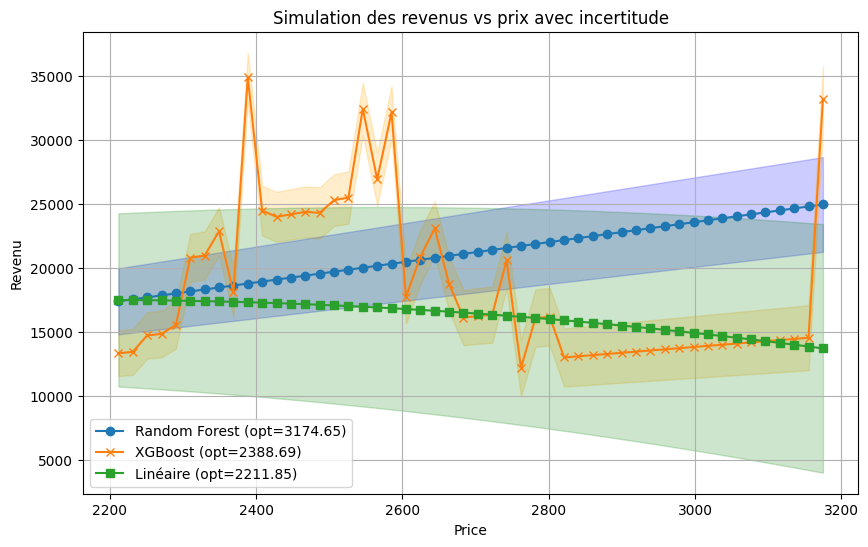

In [11]:
# Plage de prix à tester
prix_range = np.linspace(df_prod["price"].min(), df_prod["price"].max(), 50)

# Fonction pour prédire unités et estimer l'incertitude
def predict_with_uncertainty(model, prix, scaler=None, rmse=None, poly_transform=None):
    units_pred = []
    for p in prix:
        X_opt = pd.DataFrame({
            "price": [p],
            "week_sin": [np.sin(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)],
            "week_cos": [np.cos(2 * np.pi * ((df_prod["Week"].max() + 1) % 52) / 52)]
        })

        # Normalisation si nécessaire
        if scaler:
            X_opt = scaler.transform(X_opt)

        # Transformation polynomiale si nécessaire
        if poly_transform:
            X_opt = poly_transform.transform(X_opt)

        units_pred.append(model.predict(X_opt)[0])

    units_pred = np.array(units_pred)

    # Création des bandes si RMSE fourni
    if rmse:
        upper = units_pred + rmse
        lower = units_pred - rmse
        return units_pred, upper, lower

    return units_pred

# Prédictions pour chaque modèle
units_rf, rf_upper, rf_lower = predict_with_uncertainty(model, prix_range, rmse=rmse_rf)  # RandomForest non normalisé
units_xgb, xgb_upper, xgb_lower = predict_with_uncertainty(xgb_model, prix_range, scaler=scaler_X, rmse=rmse_xgb)
units_lin, lin_upper, lin_lower = predict_with_uncertainty(lin_model, prix_range, scaler=scaler_X_lin, rmse=rmse_lin)

# Revenus
revenus_rf = prix_range * units_rf
revenus_xgb = prix_range * units_xgb
revenus_lin = prix_range * units_lin

revenus_rf_upper = prix_range * rf_upper
revenus_rf_lower = prix_range * rf_lower
revenus_xgb_upper = prix_range * xgb_upper
revenus_xgb_lower = prix_range * xgb_lower
revenus_lin_upper = prix_range * lin_upper
revenus_lin_lower = prix_range * lin_lower

# Tracé
plt.figure(figsize=(10, 6))

# Random Forest
plt.plot(prix_range, revenus_rf, label=f'Random Forest (opt={prix_range[np.argmax(revenus_rf)]:.2f})', marker='o')
plt.fill_between(prix_range, revenus_rf_lower, revenus_rf_upper, color='blue', alpha=0.2)

# XGBoost
plt.plot(prix_range, revenus_xgb, label=f'XGBoost (opt={prix_range[np.argmax(revenus_xgb)]:.2f})', marker='x')
plt.fill_between(prix_range, revenus_xgb_lower, revenus_xgb_upper, color='orange', alpha=0.2)

# Régression Linéaire
plt.plot(prix_range, revenus_lin, label=f'Linéaire (opt={prix_range[np.argmax(revenus_lin)]:.2f})', marker='s')
plt.fill_between(prix_range, revenus_lin_lower, revenus_lin_upper, color='green', alpha=0.2)

plt.xlabel("Price")
plt.ylabel("Revenu")
plt.title("Simulation des revenus vs prix avec incertitude")
plt.legend()
plt.grid(True)
plt.show()


In [12]:


print("Random Forest -> RMSE:", rmse_rf, "MAE:", mae_rf, "R²:", r2_score(y, y_pred_rf))
print("XGBoost -> RMSE:", rmse_xgb, "MAE:", mae_xgb, "R²:", r2_score(y, y_pred_xgb))
print("Linéaire -> RMSE:", rmse_lin, "MAE:", mae_lin, "R²:", r2_score(y, y_pred_lin))


Random Forest -> RMSE: 1.1659610269125935 MAE: 0.9293023255813954 R²: 0.8644298684021285
XGBoost -> RMSE: 0.8052931423029323 MAE: 0.5931098461151123 R²: 0.9353298544883728
Linéaire -> RMSE: 3.0603996903445205 MAE: 2.409035613447964 R²: 0.06598844689210304


In [13]:
df_prod[["price","Units_Sold"]].corr()

,price,Units_Sold
price,1.000000,-0.200802
Units_Sold,-0.200802,1.000000


identification des produits ou les ventes dependent du prix

In [14]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dossier contenant tous les fichiers produits
dossier = r"C:/Users/admin/Documents/stage mexico/VIDEO/split_data_VIDEO"

# Nouveau dossier pour les produits élastiques
dossier_cible = os.path.join(dossier, "produits_elastiques")
os.makedirs(dossier_cible, exist_ok=True)

# Seuil de corrélation pour considérer un produit sensible
seuil_corr = 0.4

# DataFrame final pour toutes les métriques
df_metrics = pd.DataFrame(columns=["Produit", "Model", "RMSE", "MAE", "R2", "Price_Units_Corr"])

# Parcourir tous les fichiers Excel/CSV du dossier
for fichier in os.listdir(dossier):
    if fichier.endswith(".xlsx") or fichier.endswith(".csv"):
        chemin_fichier = os.path.join(dossier, fichier)
        nom_produit = os.path.splitext(fichier)[0]

        # Charger le fichier
        df = pd.read_excel(chemin_fichier) if fichier.endswith(".xlsx") else pd.read_csv(chemin_fichier)

        # Agréger pour rendre Year + Week unique
        df = df.groupby(["Year", "Week"], as_index=False).agg({
            "Total_Sales": "sum",
            "Units_Sold": "sum",
            "Department": "first",
            "Product_ID": "first",
            "Product_Description": "first",
            "Brand": "first",
            "Product_Group": "first"
        })

        # Créer les features temporelles
        df["tendance"] = np.arange(len(df))
        df["week_sin"] = np.sin(2 * np.pi * df["Week"] / 52)
        df["week_cos"] = np.cos(2 * np.pi * df["Week"] / 52)

        # Ajouter le prix
        df["price"] = df["Total_Sales"] / df["Units_Sold"]
        df["price"] = df["price"].replace([np.inf, -np.inf], np.nan)
        df["price"] = df["price"].fillna(df["price"].mean())

        # Calculer la corrélation entre price et Units_Sold
        corr_price_units = df["price"].corr(df["Units_Sold"])

        # Vérifier si produit élastique
        if abs(corr_price_units) >= seuil_corr:
            shutil.copy2(chemin_fichier, os.path.join(dossier_cible, fichier))
            print(f"{fichier} → corr={corr_price_units:.2f} → copié dans 'produits_elastiques'")

            # Variables explicatives et cible (tout le dataset)
            X = df[["price", "week_sin", "week_cos"]]
            y = df["Units_Sold"]

            # Normaliser uniquement le prix
            scaler = StandardScaler()
            X_scaled = X.copy()
            X_scaled[["price"]] = scaler.fit_transform(X[["price"]])

            # Définir les modèles
            models = {
                "LinearRegression": LinearRegression(),
                "RandomForest": RandomForestRegressor(random_state=42),
                "XGBoost": XGBRegressor(random_state=42, eval_metric='rmse')
            }

            # Entraîner et calculer métriques sur tout le dataset
            for name, model in models.items():
                model.fit(X_scaled, y)
                y_pred = model.predict(X_scaled)
                mse = mean_squared_error(y, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y, y_pred)
                r2 = r2_score(y, y_pred)

                df_metrics = pd.concat([df_metrics, pd.DataFrame([{
                    "Produit": nom_produit,
                    "Model": name,
                    "RMSE": rmse,
                    "MAE": mae,
                    "R2": r2,
                    "Price_Units_Corr": corr_price_units
                }])], ignore_index=True)

# Afficher le DataFrame final
print(df_metrics)


2691337.csv → corr=-0.67 → copié dans 'produits_elastiques'


C:\Users\admin\AppData\Local\Temp\ipykernel_7076\670304849.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([{


2691341.csv → corr=0.66 → copié dans 'produits_elastiques'
2732815.csv → corr=0.77 → copié dans 'produits_elastiques'
2756901.csv → corr=0.57 → copié dans 'produits_elastiques'
2822670.csv → corr=0.45 → copié dans 'produits_elastiques'
2826976.csv → corr=-0.59 → copié dans 'produits_elastiques'
2833281.csv → corr=-0.62 → copié dans 'produits_elastiques'
2841994.csv → corr=-0.44 → copié dans 'produits_elastiques'
2854108.csv → corr=0.45 → copié dans 'produits_elastiques'
    Produit             Model       RMSE        MAE        R2  \
0   2691337  LinearRegression  15.533063  10.364283  0.474346   
1   2691337      RandomForest   5.290868   2.769847  0.939013   
2   2691337           XGBoost   0.026340   0.018850  0.999999   
3   2691341  LinearRegression   4.417584   3.419795  0.457588   
4   2691341      RandomForest   1.323767   0.960454  0.951294   
5   2691341           XGBoost   0.145173   0.024632  0.999414   
6   2732815  LinearRegression   6.554618   5.304602  0.609547   
7   2

In [15]:
df_metrics.shape

(27, 6)

In [16]:
dossier_produits = r"C:/Users/admin/Documents/stage mexico/VIDEO/split_data_VIDEO\produits_elastiques"
dossier_final = os.path.join(dossier_produits, "produits_analyse")
os.makedirs(dossier_final, exist_ok=True)

for fichier in os.listdir(dossier_produits):
    if fichier.endswith(".xlsx") or fichier.endswith(".csv"):
        nom_produit = os.path.splitext(fichier)[0]
        sous_dossier = os.path.join(dossier_final, nom_produit)
        os.makedirs(sous_dossier, exist_ok=True)
        
        shutil.copy2(os.path.join(dossier_produits, fichier), sous_dossier)
        
        nb = nbf.v4.new_notebook()
        
        texte_intro = f"# Analyse du produit {nom_produit}\n\nCe notebook applique LinearRegression, RandomForest et XGBoost pour trouver le prix optimal."
        nb.cells.append(nbf.v4.new_markdown_cell(texte_intro))
        
        code_cell = f"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_excel("{fichier}") if "{fichier}".endswith(".xlsx") else pd.read_csv("{fichier}")

# Agréger pour rendre Year + Week unique
df = (
    df.groupby(["Year", "Week"], as_index=False)
    .agg({{
        "Total_Sales": "sum",
        "Units_Sold": "sum",
        "Department": "first",
        "Product_ID": "first",
        "Product_Description": "first",
        "Brand": "first",
        "Product_Group": "first"
    }})
)

# Préparer features
df["date"] = pd.to_datetime(df["Year"].astype(str) + df["Week"].astype(str) + '1', format='%Y%W%w')
df["tendance"] = np.arange(len(df))
df["week_sin"] = np.sin(2 * np.pi * df["Week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["Week"] / 52)
df["price"] = df["Total_Sales"] / df["Units_Sold"]

df["price"] = df["price"].replace([np.inf, -np.inf], np.nan)
df["price"] = df["price"].fillna(df["price"].mean())

# Variables explicatives et cible (tout le dataset)
X = df[["price", "week_sin", "week_cos"]]
y = df["Units_Sold"]

# Normalisation
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Définition des modèles
models = {{
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, eval_metric='rmse')
}}

results = {{}}

for name, model in models.items():
    # Entraînement et prédiction sur tout le dataset
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Évaluation
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calcul du prix optimal
    prix_range = np.linspace(df["price"].min(), df["price"].max(), 50)
    revenus = []
    for p in prix_range:
        X_opt = pd.DataFrame({{
            "price": [p],
            "week_sin": [np.sin(2 * np.pi * ((df["Week"].max()+1) % 52) / 52)],
            "week_cos": [np.cos(2 * np.pi * ((df["Week"].max()+1) % 52) / 52)]
        }})
        X_opt_scaled = scaler_X.transform(X_opt)
        units_pred = model.predict(X_opt_scaled)[0]
        revenus.append(p * units_pred)
    prix_opt = prix_range[np.argmax(revenus)]

    results[name] = {{"R2": r2, "RMSE": rmse, "MAE": mae, "Prix_optimal": prix_opt}}

# Affichage des résultats
for name, res in results.items():
    print(f"=== {{name}} ===")
    print(f"R2: {{res['R2']:.3f}}, RMSE: {{res['RMSE']:.3f}}, MAE: {{res['MAE']:.3f}}, Prix optimal: {{res['Prix_optimal']:.2f}}\\n")

# Tracé des revenus vs prix
plt.figure(figsize=(10,6))
for name, model in models.items():
    revenus = []
    for p in prix_range:
        X_opt = pd.DataFrame({{
            "price": [p],
            "week_sin": [np.sin(2 * np.pi * ((df["Week"].max()+1) % 52) / 52)],
            "week_cos": [np.cos(2 * np.pi * ((df["Week"].max()+1) % 52) / 52)]
        }})
        X_opt_scaled = scaler_X.transform(X_opt)
        units_pred = model.predict(X_opt_scaled)[0]
        revenus.append(p * units_pred)
    plt.plot(prix_range, revenus, label=name)

plt.xlabel("Prix")
plt.ylabel("Revenu prévu")
plt.title("Simulation revenus vs prix")
plt.legend()
plt.grid(True)
plt.show()
"""

        nb.cells.append(nbf.v4.new_code_cell(code_cell))
        
        chemin_nb = os.path.join(sous_dossier, f"analyse_{nom_produit}.ipynb")
        with open(chemin_nb, "w", encoding="utf-8") as f:
            nbf.write(nb, f)

print("Notebooks créés pour tous les produits élastiques !")


Notebooks créés pour tous les produits élastiques !


In [17]:
import os

dossier_final = r"C:\Users\admin\Documents\stage mexico\Bases practicantes\split_data_LINEA_BLANCA\produits_elastiques\produits_analyse"

# Lister tous les sous-dossiers (un par produit)
sous_dossiers = [name for name in os.listdir(dossier_final) if os.path.isdir(os.path.join(dossier_final, name))]

print(f"Nombre de dossiers créés : {len(sous_dossiers)}")
print("Liste des dossiers :", sous_dossiers)


Nombre de dossiers créés : 43
Liste des dossiers : ['1585561', '1707028', '2317805', '2329604', '2365459', '2365462', '2365463', '2380084', '2385662', '2419712', '2504164', '2548069', '2595365', '2595367', '2595368', '2595369', '2595371', '2595372', '2595374', '2609159', '2628907', '2629962', '2636108', '2642437', '2667251', '2677640', '2691655', '2756310', '2756773', '2773105', '2773106', '2773107', '2773109', '2787230', '2810923', '2838333', '2839816', '2839818', '2848118', '2852765', '2852769', '2852771', '2853935']


In [18]:
df_metrics.head(40)

,Produit,Model,RMSE,MAE,R2,Price_Units_Corr
0,2691337,LinearRegression,15.533063,10.364283,0.474346,-0.670262
1,2691337,RandomForest,5.290868,2.769847,0.939013,-0.670262
2,2691337,XGBoost,0.026340,0.018850,0.999999,-0.670262
3,2691341,LinearRegression,4.417584,3.419795,0.457588,0.664415
4,2691341,RandomForest,1.323767,0.960454,0.951294,0.664415
5,2691341,XGBoost,0.145173,0.024632,0.999414,0.664415
6,2732815,LinearRegression,6.554618,5.304602,0.609547,0.769275
7,2732815,RandomForest,1.909208,1.347130,0.966873,0.769275
8,2732815,XGBoost,0.005317,0.003993,1.000000,0.769275
9,2756901,LinearRegression,12.307164,8.610221,0.427207,0.567947
